# HY2B SWH对比

In [1]:
from HaiYangData import *
import glob

In [2]:
# 设置空间分辨率
years = ['2019','2020']
months = ['04','05','06','07','08','09']
time_window = 1800

In [3]:
# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

In [4]:
hy_alt = HaiYangData(satellite='hy', sensor='alt',resolution=10000)


In [6]:
hyfiles = []
hy_value = ['swh_ku','swh_c','rain_flag','ice_flag','surface_type']
hy_fill_value = 32767
for yea in years:
    for mon in months:
        hy_dir_path = r'/mnt/data12/users/hanlu/data/hy2b/ALT/'+yea + '/' + mon
        hyfiles = hyfiles + (glob.glob(hy_dir_path + '/*.nc'))
hyfiles.sort()


%%time

hy_ori_df = pd.DataFrame(np.column_stack((hy_alt.alt_from_nc_files(hyfiles, value=hy_value))), columns=['lon', 'lat', 'time']+hy_value)

# 删除无效点,只处理北纬66°以上的数据
hy_df = hy_ori_df.drop(list(np.where(hy_ori_df['swh_ku'] == hy_fill_value)[0][:]))
hy_df = hy_alt.data_filter(hy_df,'lat',66)

In [7]:
hy_df.to_csv('hy' +str( years) + str(months) + '.csv')

In [5]:
%%time
hy_df = pd.read_csv(r"/home/hanlu/python_workfile/remote_sensing/hy['2019', '2020']['04', '05', '06', '07', '08', '09'].csv")

CPU times: user 374 ms, sys: 64.4 ms, total: 439 ms
Wall time: 437 ms


In [6]:
# 将投影数据添加到dataframe中
hy_alt.add_proj(hy_df, transformer)

# 交叉点平均化
hy_mean_grid = hy_alt.coincident_point_mean(hy_df,'swh_ku')

# 获得XYmgrid
hy_x_map, hy_y_map = hy_alt.get_map_grid(transformer_back)

<ipython-input-7-1e5fcfe383a5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(hy_x_map, hy_y_map, data=hy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)


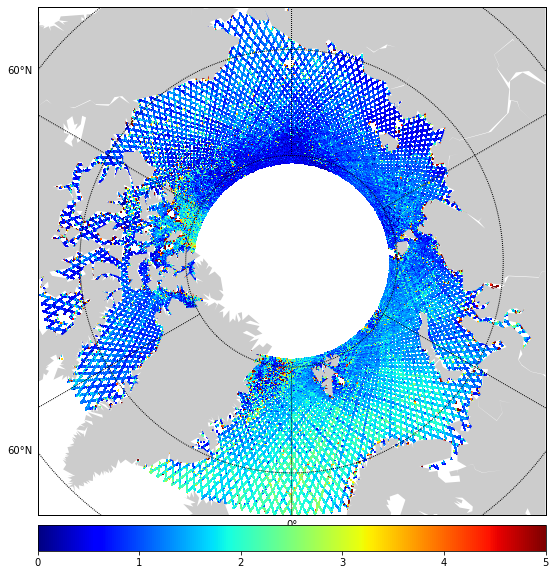

In [7]:
plt.figure(figsize=(10, 10))
hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')
hy_m.pcolormesh(hy_x_map, hy_y_map, data=hy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
hy_m.colorbar(location='bottom')
hy_m.fillcontinents() 
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
# plt.title("HY2B SWH  "+ year+ month)
plt.show()
plt.close()

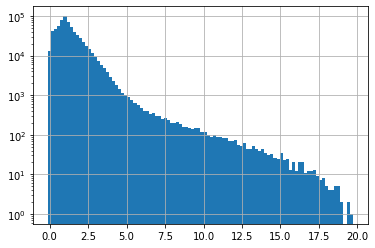

In [8]:
fig , ax = plt.subplots()
hy_df['swh_ku'].hist(ax=ax, bins=100)
ax.set_yscale('log')
plt.show()

# Cryosat 数据处理

In [11]:
cyfiles = []
cy_fill_value = -32768

for yea in years:
    for mon in months:
        cy_dir_path = r'/mnt/data12/users/hanlu/data/cryosat2/'+yea + '/' + mon
        cyfiles = cyfiles + (glob.glob(cy_dir_path + '/*.nc'))
cyfiles.sort()

In [9]:
cy_siral = HaiYangData(satellite='cy', sensor='siral',resolution=10000)

In [13]:
%%time
cy_value = ['swh_ocean_01_ku']

cy_ori_df = pd.DataFrame(np.column_stack((cy_siral.cy_siral_from_nc(cyfiles, value=cy_value))), columns=['lon', 'lat', 'time']+cy_value)

# 删除无效点,只处理北纬66°以上的数据
cy_df = cy_ori_df.drop(list(np.where(cy_ori_df['swh_ocean_01_ku'] == cy_fill_value)[0][:]))
cy_df = cy_siral.data_filter(cy_df,'lat',66)

In [14]:
cy_df.to_csv('cy' +str( years) + str(months) + '.csv')

In [10]:
%%time
cy_df = pd.read_csv(r"/home/hanlu/python_workfile/remote_sensing/cy['2019', '2020']['04', '05', '06', '07', '08', '09'].csv")

CPU times: user 107 ms, sys: 12 ms, total: 119 ms
Wall time: 119 ms


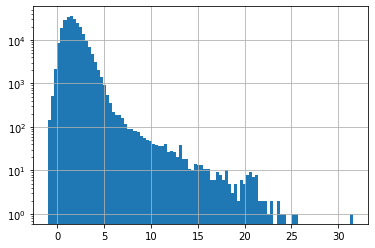

In [11]:
fig,ax = plt.subplots()
cy_df.swh_ocean_01_ku.hist(ax=ax,bins=100)
ax.set_yscale('log')

In [12]:
# 将投影数据添加到dataframe中
cy_siral.add_proj(cy_df, transformer)

# 交叉点平均化
cy_mean_grid = cy_siral.coincident_point_mean(cy_df,'swh_ocean_01_ku')

# 获得XYmgrid
cy_x_map, cy_y_map = cy_siral.get_map_grid(transformer_back)

<ipython-input-13-83a174753b7c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cy_m.pcolormesh(cy_x_map, cy_y_map, data=cy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)


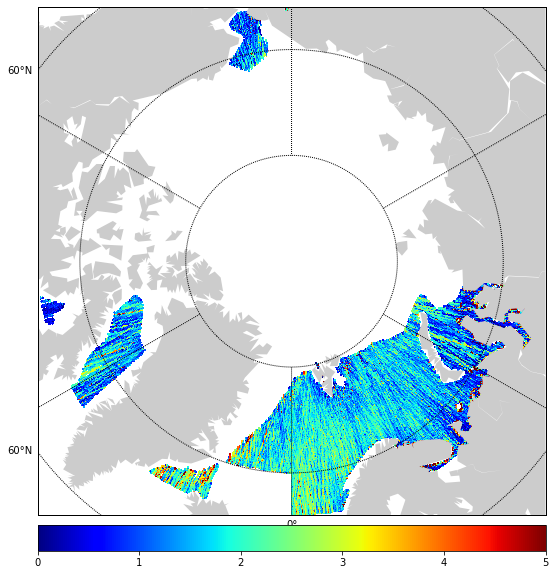

In [13]:
plt.figure(figsize=(10, 10))
cy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')
cy_m.pcolormesh(cy_x_map, cy_y_map, data=cy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
cy_m.colorbar(location='bottom')
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
# plt.title("cy2 SWH  "+ year+ month)
plt.show()
plt.close()

# ICESAT2 数据处理

In [41]:
%%time
# icesat2 的时间是从2018-01-01 00：00：00开始记的，Hy2b和cryosat2的是从2000-01-01 00：00：00开始计的
# 2018-01-01 00：00：00 与2000-01-01 00：00：00 相差了568080000秒
correction_second = 568080000
is_fill_value = 32767
isfiles = []
is_value = ['swh']
for yea in years:
    for mon in months:
        is_dir_path = r'/mnt/data12/users/hanlu/data/icesat2/'+yea + '/' + mon
        isfiles = isfiles + (glob.glob(is_dir_path + '/*.h5'))
isfiles.sort()

CPU times: user 4.34 ms, sys: 3.95 ms, total: 8.29 ms
Wall time: 7.08 ms


In [14]:
is_atlas = HaiYangData(satellite='is', sensor='atlas',resolution=10000)

In [42]:
%%time
is_value = ['swh']

is_ori_df = pd.DataFrame(np.column_stack((is_atlas.is_atlas_from_nc(isfiles, value=is_value))), columns=['lon', 'lat', 'time']+is_value)

/mnt/data12/users/hanlu/data/icesat2/2019/06/ATL12_20190626151041_13650301_003_01.h5 gt1r
/mnt/data12/users/hanlu/data/icesat2/2019/06/ATL12_20190626151041_13650301_003_01.h5 gt2r
/mnt/data12/users/hanlu/data/icesat2/2019/06/ATL12_20190626151041_13650301_003_01.h5 gt3r
CPU times: user 37min 42s, sys: 27min 17s, total: 1h 5min
Wall time: 1h 49min 26s


In [43]:
# 删除无效点,只处理北纬66°以上的数据
is_df = is_ori_df.drop(list(np.where(is_ori_df['swh'] == is_fill_value)[0][:]))
is_df = is_atlas.data_filter(is_df,'lat',66)

In [44]:
is_df.to_csv('is' +str( years) + str(months) + '.csv')

In [15]:
%%time
is_df = pd.read_csv(r"/home/hanlu/python_workfile/remote_sensing/is['2019', '2020']['04', '05', '06', '07', '08', '09'].csv")

CPU times: user 11 s, sys: 1.12 s, total: 12.1 s
Wall time: 12.1 s


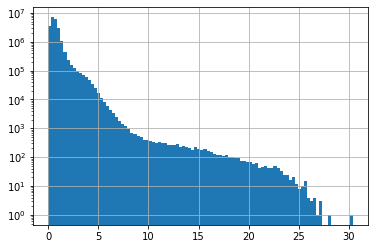

In [16]:
fig,ax = plt.subplots()
is_df.swh.hist(ax=ax,bins=100)
ax.set_yscale('log')

In [17]:
# 将投影数据添加到dataframe中
is_atlas.add_proj(is_df, transformer)

# 交叉点平均化
is_mean_grid = is_atlas.coincident_point_mean(is_df,'swh')

# 获得XYmgrid
is_x_map, is_y_map = is_atlas.get_map_grid(transformer_back)

<ipython-input-18-adb2b6d25290>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  is_m.pcolormesh(is_x_map, is_y_map, data=is_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)


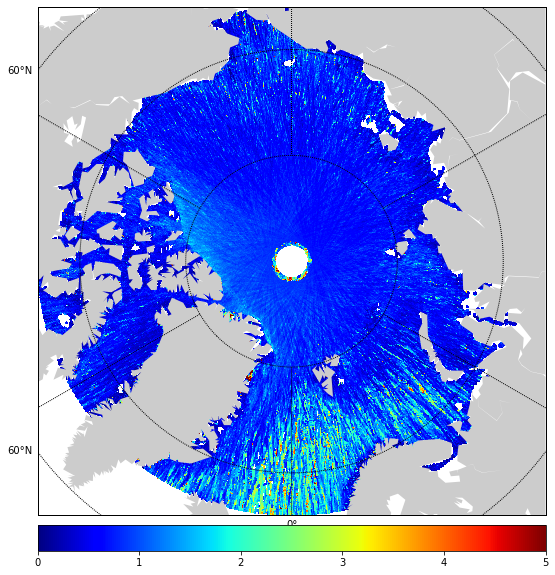

In [18]:
plt.figure(figsize=(10, 10))
is_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')
is_m.pcolormesh(is_x_map, is_y_map, data=is_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
is_m.colorbar(location='bottom')
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
# plt.title("is2 SWH  "+ year+ month)
plt.show()
plt.close()

# 对比hy与cryosat交叉点


In [19]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_cy_grid = hy_mean_grid - cy_mean_grid
hy_cy_diff_grid = np.argwhere(np.isnan(hy_cy_grid)!= True)

In [20]:
hy_cy_diff_grid.shape

(17635, 2)

In [21]:
cy_time_dict = dict(cy_siral.coincident_time_log(cy_df,value='swh_ocean_01_ku'))
hy_time_dict = dict(hy_alt.coincident_time_log(hy_df,value='swh_ku'))


In [22]:
# 创建一个用来存储点对的list
hy_cy_coincident_list = []
hy_cy_time_list = []
for i in range(hy_cy_diff_grid.shape[0]): 
    diff_x = hy_cy_diff_grid[i][0]
    diff_y = hy_cy_diff_grid[i][1]
    if diff_y>(hy_alt.nlat / 2):
        diff_y -= hy_alt.nlat
    key = str(diff_x) + '+' + str(diff_y)
    
    for cy_time_key in cy_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            hy_cy_time_list.append(np.abs(hy_time_key - cy_time_key))
            hy_cy_time_list.append(key)
            
            if np.abs(hy_time_key - cy_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(cy_time_key)
                coincident_value.append(cy_time_dict[key][cy_time_key])
                hy_cy_coincident_list.append(coincident_value)


In [23]:
hy_cy_df = pd.DataFrame(hy_cy_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])

hy_cy_df['hy_time_round'] = ((hy_cy_df['hy_time'].astype(np.float))/time_window).astype(np.int)

hy_cy_df['other_time_round'] = ((hy_cy_df['other_time'].astype(np.float))/time_window).astype(np.int)

In [200]:
hy_cy_mean_df = hy_cy_df.groupby(['ij','hy_time_round','other_time_round']).mean()

hy_cy_mean_df['diff'] = hy_cy_mean_df['hy_value'] - hy_cy_mean_df['other_value']


In [201]:
hy_cy_mean_df = hy_cy_mean_df.drop(hy_cy_mean_df[hy_cy_mean_df.hy_value > hy_cy_mean_df['diff'].std() * 5 ].index)
hy_cy_mean_df = hy_cy_mean_df.drop(hy_cy_mean_df[hy_cy_mean_df.other_value > hy_cy_mean_df['diff'].std() * 5 ].index)

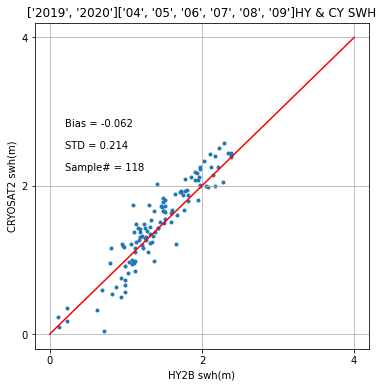

In [202]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_cy_mean_df['hy_value'], hy_cy_mean_df['other_value'], marker='.')
plt.plot(np.linspace(0,4),np.linspace(0,4),color='r')
x_tick = range(0,5,2)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(0.2, 2.8, 'Bias = '+str(round(hy_cy_mean_df['diff'].mean(), 3)))
plt.text(0.2, 2.5, 'STD = '+str(round(hy_cy_mean_df['diff'].std(), 3)))
plt.text(0.2,2.2,'Sample# = ' + str(hy_cy_mean_df.shape[0]))
plt.xlabel('HY2B ' + 'swh' + '(m)')
plt.ylabel('CRYOSAT2 ' + 'swh' + '(m)')
plt.title(str(years) + str(months) + 'HY & CY SWH' )
plt.savefig(r'output/'+'2019-2020'+ str(months)  +'HY & CY' + 'swh' +' '+ 'scatter_plot.jpg')

# HY和CRYOSAT2交叉点在图像上绘制出来

In [42]:
'''hy_cy_mean_df = hy_cy_df.groupby(hy_cy_df['ij']).mean()
hy_cy_mean_df['diff'] = hy_cy_mean_df['hy_value'] - hy_cy_mean_df['other_value']'''

In [43]:
hy_cy_draw_diff_grid = hy_alt.get_nan_grid(hy_alt.nlat, hy_alt.nlon)
for i,index in enumerate(hy_cy_mean_df.index):
    hy_cy_draw_diff_grid[int(index.split('+')[0])][int(index.split('+')[1])] = hy_cy_mean_df.loc[hy_cy_mean_df.index[i]]['diff']


<ipython-input-44-43eaa4ab7e02>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = cy_m.pcolormesh(cy_x_map, cy_y_map, data=hy_cy_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=1, vmin = -1)


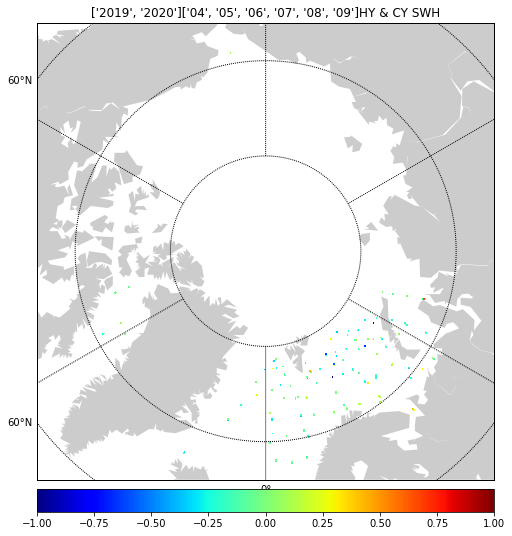

In [44]:
plt.figure(figsize=(9, 9))
cy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')

h = cy_m.pcolormesh(cy_x_map, cy_y_map, data=hy_cy_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=1, vmin = -1)

cy_m.colorbar(location='bottom')
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title(str(years) + str(months) + 'HY & CY SWH' )
plt.savefig(r'output/'+'all/'+'2019-2020' +  str(months) +'HY & CY' + 'swh' + '.jpg')
plt.show()
plt.close()

# 对比hy与icesat交叉点


In [30]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_is_grid = hy_mean_grid - is_mean_grid
hy_is_diff_grid = np.argwhere(np.isnan(hy_is_grid)!= True)


In [31]:
%%time
is_time_dict = dict(is_atlas.coincident_time_log(is_df,value='swh'))


CPU times: user 9min 7s, sys: 2.5 s, total: 9min 10s
Wall time: 9min 10s


In [32]:
# 创建一个用来存储点对的list
hy_is_coincident_list = []
hy_is_time_list = []
for i in range(hy_is_diff_grid.shape[0]): 
    diff_x = hy_is_diff_grid[i][0]
    diff_y = hy_is_diff_grid[i][1]
    if diff_y>(hy_alt.nlat / 2):
        diff_y -= hy_alt.nlat
    key = str(diff_x) + '+' + str(diff_y)
    
    for is_time_key in is_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            hy_is_time_list.append(np.abs(hy_time_key - is_time_key))
            hy_is_time_list.append(key)
            
            if np.abs(hy_time_key - is_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(is_time_key)
                coincident_value.append(is_time_dict[key][is_time_key])
                hy_is_coincident_list.append(coincident_value)

In [33]:

hy_is_df = pd.DataFrame(hy_is_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])

hy_is_df['hy_time_round'] = ((hy_is_df['hy_time'].astype(np.float))/time_window).astype(np.int)

hy_is_df['other_time_round'] = ((hy_is_df['other_time'].astype(np.float))/time_window).astype(np.int)

In [78]:

hy_is_mean_df = hy_is_df.groupby(['ij','hy_time_round','other_time_round']).mean()

hy_is_mean_df['diff'] = hy_is_mean_df['hy_value'] - hy_is_mean_df['other_value']


In [113]:
hy_is_mean_df = hy_is_mean_df.drop(hy_is_mean_df[hy_is_mean_df.hy_value > hy_is_mean_df['diff'].std() * 5 ].index)
hy_is_mean_df = hy_is_mean_df.drop(hy_is_mean_df[hy_is_mean_df.other_value > hy_is_mean_df['diff'].std() * 5 ].index)

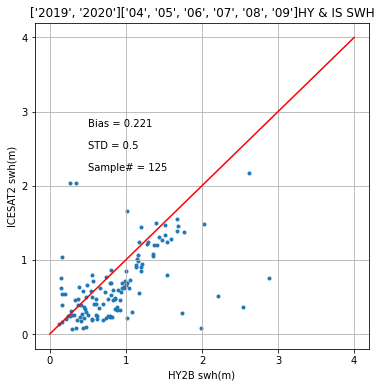

In [123]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_is_mean_df['hy_value'], hy_is_mean_df['other_value'], marker='.')
plt.plot(np.linspace(0,4),np.linspace(0,4),color='r')
x_tick = range(0,5,1)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(0.5, 2.8, 'Bias = '+str(round(hy_is_mean_df['diff'].mean(), 3)))
plt.text(0.5, 2.5, 'STD = '+str(round(hy_is_mean_df['diff'].std(), 3)))
plt.text(0.5,2.2,'Sample# = ' + str(hy_is_mean_df.shape[0]))
plt.xlabel('HY2B ' + 'swh' + '(m)')
plt.ylabel('ICESAT2 ' + 'swh' + '(m)')
plt.title(str(years) + str(months) + 'HY & IS SWH' )

plt.savefig(r'output/'+'2019-2020' +  str(months) +'HY & IS' + 'swh' +' '+ 'scatter_plot.jpg')

# HY和IS交叉点在图像上绘制出来

In [197]:
hy_is_draw_diff_grid = hy_alt.get_nan_grid(hy_alt.nlat, hy_alt.nlon)
for i,index in enumerate(hy_is_mean_df.index):
    hy_is_draw_diff_grid[int(index[0].split('+')[0])][int(index[0].split('+')[1])] = hy_is_mean_df.loc[hy_is_mean_df.index[i]]['diff']


<ipython-input-198-0f81444be317>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = is_m.pcolormesh(is_x_map, is_y_map, data=hy_is_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=1, vmin = -1)


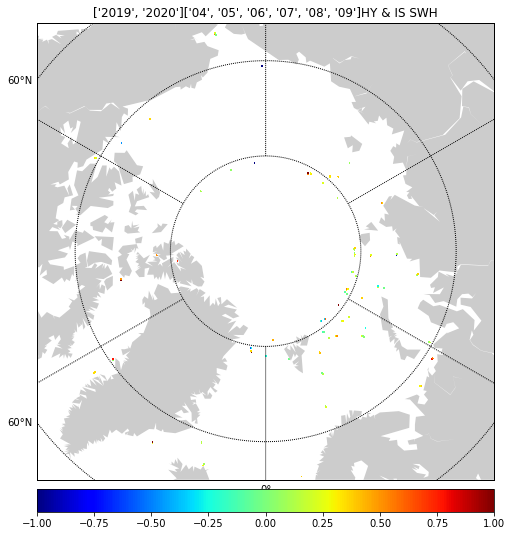

In [198]:
plt.figure(figsize=(9, 9))
is_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')

h = is_m.pcolormesh(is_x_map, is_y_map, data=hy_is_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=1, vmin = -1)

is_m.colorbar(location='bottom')
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title(str(years) + str(months) + 'HY & IS SWH' )
plt.savefig(r'output/'+'all/'+'2019-2020' +  str(months) +'HY & IS' + 'swh' + '.jpg')
plt.show()
plt.close()

# 计算交叉点最多的日期

In [57]:
import datetime
def conver_time(julian_time):
    '''
    将从'2000-01-01 00:00:00 开始的JulianDay 转换为%Y-%m-%d %H:%M:%S 格式的时间
    '''
    strTime = '2000-01-01 00:00:00'
    startTime = datetime.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S") 
    Time = (startTime + datetime.timedelta(seconds=julian_time)).strftime("%Y-%m-%d %H:%M:%S")
    return Time


    

In [204]:
hy_is_mean_df['hy_day'] = (hy_is_mean_df['hy_time']/86400).astype(np.int)
hy_is_mean_df['other_day'] = (hy_is_mean_df['other_time']/86400).astype(np.int)

hy_cy_mean_df['hy_day'] = (hy_cy_mean_df['hy_time']/86400).astype(np.int)
hy_cy_mean_df['other_day'] = (hy_cy_mean_df['other_time']/86400).astype(np.int)

In [206]:
# 统计重合点最多的日期
hy_is_top_num_day = hy_is_mean_df['hy_day'].value_counts().index[0]

hy_cy_top_num_day = hy_cy_mean_df['hy_day'].value_counts().index[0]

In [208]:
hy_cy_mean_df['hy_format_time'] = hy_cy_mean_df['hy_time'].apply(conver_time)
hy_cy_mean_df['other_format_time'] = hy_cy_mean_df['other_time'].apply(conver_time)

hy_is_mean_df['hy_format_time'] = hy_is_mean_df['hy_time'].apply(conver_time)
hy_is_mean_df['other_format_time'] = hy_is_mean_df['other_time'].apply(conver_time)

In [211]:
hy_cy_mean_df[hy_cy_mean_df['hy_day'] == hy_cy_top_num_day][['hy_format_time','other_format_time','hy_value','other_value','diff']]

,,,hy_format_time,other_format_time,hy_value,other_value,diff
ij,hy_time_round,other_time_round,,,,,
800+-58,345249,345249,2019-09-10 16:53:14,2019-09-10 16:37:44,2.023,2.3310,-0.3080
801+-58,345249,345249,2019-09-10 16:53:15,2019-09-10 16:37:43,2.048,1.9975,0.0505
833+157,345242,345242,2019-09-10 13:24:39,2019-09-10 13:19:02,1.972,2.2490,-0.2770
834+156,345242,345242,2019-09-10 13:24:40,2019-09-10 13:19:00,1.978,2.2290,-0.2510
863+-269,345256,345255,2019-09-10 20:21:47,2019-09-10 19:56:29,0.949,1.2140,-0.2650
864+-268,345256,345255,2019-09-10 20:21:49,2019-09-10 19:56:28,0.990,0.9180,0.0720
883+236,345239,345239,2019-09-10 11:40:21,2019-09-10 11:39:40,1.961,2.1110,-0.1500


In [213]:
hy_is_mean_df[hy_is_mean_df['hy_day'] == hy_is_top_num_day][['hy_format_time','other_format_time','hy_value','other_value','diff']]

,,,hy_format_time,other_format_time,hy_value,other_value,diff
ij,hy_time_round,other_time_round,,,,,
1052+-345,340608,340609,2019-06-06 00:12:07,2019-06-06 00:38:20,0.4350,0.078064,0.356936
1053+-343,340608,340609,2019-06-06 00:12:09,2019-06-06 00:38:19,0.2980,0.070312,0.227688
1053+-344,340608,340609,2019-06-06 00:12:08,2019-06-06 00:38:19,0.3500,0.076247,0.273753
1247+-121,340615,340615,2019-06-06 03:40:06,2019-06-06 03:47:40,0.2440,0.247015,-0.003015
1248+-122,340615,340615,2019-06-06 03:40:05,2019-06-06 03:47:42,0.2070,0.197230,0.009770
1248+-123,340615,340615,2019-06-06 03:40:04,2019-06-06 03:47:42,0.7940,0.229548,0.564452
1249+-124,340615,340615,2019-06-06 03:40:03,2019-06-06 03:47:44,0.5070,0.252141,0.254859
769+-96,340643,340643,2019-06-06 17:36:25,2019-06-06 17:55:44,1.4090,1.203292,0.205708
770+-96,340643,340643,2019-06-06 17:36:26,2019-06-06 17:55:43,1.3695,1.200377,0.169123
